In [20]:
"""
Degradation-Diffusion demo.
- Generates model-based time-series tabular data
- Trains a simple denoising model
- Samples synthetic series

"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Select device once and reuse: prefer MPS (Apple Silicon), then CUDA, else CPU
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')


In [21]:

class BaseDegradationProcess:
    def __init__(self, length, dim):
        self.length = length
        self.dim = dim

    def generate_episode(self, x0):
        """
        Generate crack growth trajectories for multiple initial crack lengths.
        Args:
            x0: NumPy array of initial crack lengths (shape: (n_initial_points,) or scalar)
        Returns:
            NumPy array of shape (n_initial_points, length + 1) with crack length trajectories
        """
        # Convert x0 to NumPy array if scalar, ensure 1D for consistency
        x0 = np.atleast_1d(np.asarray(x0))
        # Initialize episode array: shape (n_initial_points, length + 1)
        episode = np.zeros((x0.shape[0], self.length + 1))
        episode[:, 0] = x0  # Set initial crack lengths
        # Iterate over cycles
        for i in range(self.length):
            episode[:, i + 1] = episode[:, i] + self.xdot(episode[:, i])
        return episode

class ParisLawDegradation(BaseDegradationProcess):
    """
    Paris–Erdogan fatigue crack growth model.
    Parameters:
        C: Paris law constant (m/cycle)/(MPa*sqrt(m))^m
        m: Paris law exponent
        delta_sigma: Stress range (MPa)
        beta: Geometry factor
    """
    def __init__(self, length, dim, C=1e-12, m=3, delta_sigma=100, beta=1):
        super().__init__(length, dim)
        self.C = C
        self.m = m
        self.delta_sigma = delta_sigma
        self.beta = beta

    def delta_K(self, a):
        """
        Calculate stress intensity factor range for an array of crack lengths.
        Args:
            a: NumPy array of crack lengths (m) or scalar
        Returns:
            NumPy array of Delta K values (MPa*sqrt(m))
        """
        a = np.atleast_1d(np.asarray(a))  # Ensure input is array
        return self.delta_sigma * np.sqrt(np.pi * a) * self.beta

    def xdot(self, a):
        """
        Calculate crack growth rate (da/dN) using Paris' law for an array of crack lengths.
        Args:
            a: NumPy array of crack lengths (m) or scalar
        Returns:
            NumPy array of crack growth rates (m/cycle)
        """
        a = np.atleast_1d(np.asarray(a))  # Ensure input is array
        return self.C * (self.delta_K(a) ** self.m)

In [22]:
n0 = 100_000
paris1 = ParisLawDegradation(length=100, dim=1, C=1e-8)
episodes1 = paris1.generate_episode(x0=np.random.randn(n0)*0.0003+0.0045)  # Initial crack lengths in meters

paris2 = ParisLawDegradation(length=100, dim=1, C=3e-8)
episodes2 = paris2.generate_episode(x0=np.random.randn(n0)*0.0003+0.003)  # Initial crack lengths in meters

paris3 = ParisLawDegradation(length=100, dim=1, C=5e-8)
episodes3 = paris3.generate_episode(x0=np.random.randn(n0)*0.0003+0.0015)  # Initial crack lengths in meters

paris4 = ParisLawDegradation(length=100, dim=1, C=7e-8)
episodes4 = paris4.generate_episode(x0=np.random.randn(n0)*0.0003+0.0007)  # Initial crack lengths in meters

paris5 = ParisLawDegradation(length=100, dim=1, C=8e-8)
episodes5 = paris5.generate_episode(x0=np.random.randn(n0)*0.0003+0.0001)  # Initial crack lengths in meters

episodes = np.concatenate([episodes1, episodes2, episodes3, episodes4, episodes5], axis=0)

/var/folders/0v/dznlzgxs3nq5y9gcf4v3g2j00000gp/T/ipykernel_19621/3789931049.py:49: RuntimeWarning: invalid value encountered in sqrt
  return self.delta_sigma * np.sqrt(np.pi * a) * self.beta


In [23]:
#drop invalid values
episodes = episodes[~np.isnan(episodes).any(axis=1)]
episodes = episodes[(episodes<1).any(axis=1)]

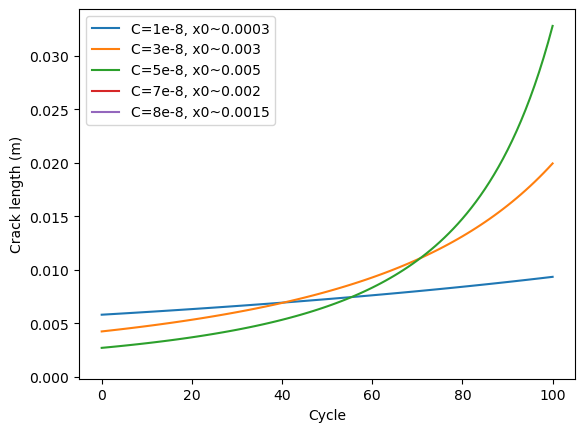

In [24]:
plt.plot(episodes1.max(0), label='C=1e-8, x0~0.0003')
plt.plot(episodes2.max(0), label='C=3e-8, x0~0.003')
plt.plot(episodes3.max(0), label='C=5e-8, x0~0.005')
plt.plot(episodes4.max(0), label='C=7e-8, x0~0.002')
plt.plot(episodes5.max(0), label='C=8e-8, x0~0.0015')
plt.xlabel('Cycle')
plt.ylabel('Crack length (m)')
plt.legend()
plt.show()

In [25]:
episodes.shape

(462030, 101)

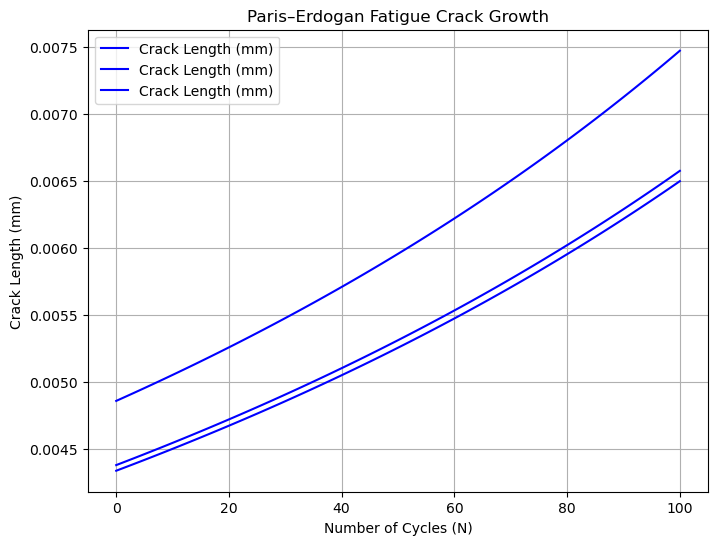

In [26]:

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(episodes[:3].T, 'b-', label='Crack Length (mm)')
plt.xlabel('Number of Cycles (N)')
plt.ylabel('Crack Length (mm)')
plt.title('Paris–Erdogan Fatigue Crack Growth')
plt.grid(True)
plt.legend()
plt.show()



In [27]:
# Normalize data
data = torch.tensor(episodes, dtype=torch.float32).to(device)
mean_data = torch.mean(data)
std_data = torch.std(data)

X = data[:,None,...] # shape N,C,L
# map min-max with shape N,C,L
X = (X - torch.min(X, 2)[0][...,None]) / (torch.max(X, 2)[0][...,None] - torch.min(X, 2)[0][...,None])
# X = (X - torch.mean(X, 2)[0][...,None]) / (torch.std(X, 2)[0][...,None])


In [28]:
X.shape

torch.Size([462030, 1, 101])

In [29]:
std_data

tensor(0.0025, device='mps:0')

In [30]:
X_std = torch.std(X)
X_std

tensor(0.2857, device='mps:0')

In [31]:
# -----------------------------
# 2. Define forward diffusion
# -----------------------------



In [32]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, t, L):
        # t: (N,) → expand to (N, L, dim)
        emb = self.mlp(t[:, None].float())   # (N, dim)
        return emb[:, None, :].repeat(1, L, 1)


In [33]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=1, dim_ff=128):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        # Self-attention
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        # Feedforward
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x


In [34]:
class TimeSeriesDiffusionModel(nn.Module):
    def __init__(self, channels, hidden_dim=32, num_blocks=2, T: int=100):
        super().__init__()
        self.T = T
        self.input_proj = nn.Linear(channels, hidden_dim)
        self.time_emb = TimeEmbedding(hidden_dim)
        self.blocks = nn.ModuleList([TransformerBlock(hidden_dim) for _ in range(num_blocks)])
        self.output_proj = nn.Linear(hidden_dim, channels)

    def forward(self, s0, ns1, t):
        x = torch.cat([s0, ns1], dim=2)  # (N, C, L)
        N, C, L = x.shape
        x = x.permute(0, 2, 1)    # (N, L, C) → tokens
        x = self.input_proj(x)    # (N, L, hidden_dim)
        # 🚨 NOTE: Double-check adding here!
        x = x + self.time_emb(t, L)  # add time embedding (NOTE: this could be problematic)

        for block in self.blocks:
            x = block(x)

        x = self.output_proj(x)   # (N, L, C)
        x = x.permute(0, 2, 1)    # back to (N, C, L)
        return x
    
    def q_sample(self, x0, t, noise):
        """
        Diffuse the data (add Gaussian noise) at step t.
        """
        # Linear beta schedule, how much noise you inject at each diffusion step
        betas = torch.linspace(1e-6, 1e-1, steps=self.T).to(x0.device)
        self.betas = betas
        alphas = 1.0 - betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        sqrt_ab = torch.sqrt(alphas_bar[t])[:, None, None]
        sqrt_one_minus_ab = torch.sqrt(1 - alphas_bar[t])[:, None, None]

        return sqrt_ab * x0 + sqrt_one_minus_ab * noise


In [35]:
# -----------------------------
# 3. denoising model
# -----------------------------
class DegDiffusion(nn.Module):
    def __init__(self, channels, sl, hidden=64, T: int=100):
        super().__init__()
        self.T = T # total diffusion steps
        self.sl = sl
        self.net1 = nn.Sequential(
            nn.Conv1d(channels, channels*4, kernel_size=3, padding=1),
            nn.Flatten(),
            nn.Linear(channels*4*self.sl, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.net2 = nn.Sequential(
            nn.Linear(hidden+1, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.sl)
        )

        self.net3 = nn.Sequential(
            nn.Conv1d(1, channels, kernel_size=3, padding=1)
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                # small gain if it's the last layer
                gain = 0.01 if m.out_features == self.sl else 1.0
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                m.weight.data.mul_(gain)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def forward(self, s0, ns1, t):
        #append time embedding (scaled)
        t = t.float().unsqueeze(1) / self.T
        x_net1 = torch.cat([s0, ns1], dim=2) # available signal + noisy signal
        y_net1 = self.net1(x_net1)
        x_net2 = torch.cat([y_net1, t], dim=1)
        y_net2 = self.net2(x_net2)
        x_net3 = y_net2.unsqueeze(1) # add channel dimension
        y_net3 = self.net3(x_net3)

        return y_net3
    
    def q_sample(self, x0, t, noise):
        """
        Diffuse the data (add Gaussian noise) at step t.
        """
        # Linear beta schedule, how much noise you inject at each diffusion step
        betas = torch.linspace(1e-6, 1e-2, steps=self.T).to(x0.device)
        self.betas = betas
        alphas = 1.0 - betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        sqrt_ab = torch.sqrt(alphas_bar[t])[:, None, None]
        sqrt_one_minus_ab = torch.sqrt(1 - alphas_bar[t])[:, None, None]

        return sqrt_ab * x0 + sqrt_one_minus_ab * noise


In [36]:
# -----------------------------
# 3.1 Define model (imported from src/degdiff/model_def.py)
# -----------------------------


device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model (choose TimeSeriesDiffusionModel or DegDiffusion)
model = TimeSeriesDiffusionModel(channels=X.shape[1]).to(device)
# model = DegDiffusion(channels=X.shape[1], sl=X.shape[2]).to(device)


In [37]:

# -----------------------------
# 4. Training loop
# -----------------------------
bs = 32
opt = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
s0_len = 50 # length of available signal

for epoch in range(50_000):
    idx = torch.randint(0, X.shape[0], (bs,))
    x0 = X[idx]
    t = torch.randint(0, model.T, (bs,)).to(device)
    noise = (torch.randn_like(x0)).to(device)
    xt = model.q_sample(x0, t, noise)
    s0 = x0[:,:,:s0_len] # available signal
    ns1 = xt[:,:,s0_len:] # noisy signal 
    noise1 = noise[:,:,s0_len:]
    noise0 = torch.zeros_like(s0).to(device)# no noise in available signal
    output_noise = torch.cat([noise0, noise1], dim=2)
    pred_noise = model(s0, ns1, t)
    loss = loss_fn(pred_noise, output_noise)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

Epoch 0, Loss 0.5963
Epoch 50, Loss 0.4716
Epoch 50, Loss 0.4716
Epoch 100, Loss 0.4285
Epoch 100, Loss 0.4285
Epoch 150, Loss 0.2822
Epoch 150, Loss 0.2822
Epoch 200, Loss 0.1672
Epoch 200, Loss 0.1672
Epoch 250, Loss 0.1342
Epoch 250, Loss 0.1342
Epoch 300, Loss 0.1157
Epoch 300, Loss 0.1157
Epoch 350, Loss 0.1109
Epoch 350, Loss 0.1109
Epoch 400, Loss 0.1148
Epoch 400, Loss 0.1148
Epoch 450, Loss 0.0693
Epoch 450, Loss 0.0693
Epoch 500, Loss 0.1130
Epoch 500, Loss 0.1130
Epoch 550, Loss 0.0750
Epoch 550, Loss 0.0750
Epoch 600, Loss 0.0848
Epoch 600, Loss 0.0848
Epoch 650, Loss 0.0924
Epoch 650, Loss 0.0924
Epoch 700, Loss 0.0548
Epoch 700, Loss 0.0548
Epoch 750, Loss 0.0766
Epoch 750, Loss 0.0766
Epoch 800, Loss 0.0527
Epoch 800, Loss 0.0527
Epoch 850, Loss 0.1100
Epoch 850, Loss 0.1100
Epoch 900, Loss 0.1101
Epoch 900, Loss 0.1101
Epoch 950, Loss 0.0449
Epoch 950, Loss 0.0449
Epoch 1000, Loss 0.0661
Epoch 1000, Loss 0.0661
Epoch 1050, Loss 0.0927
Epoch 1050, Loss 0.0927
Epoch 1100,

In [38]:
s0.shape, ns1.shape

(torch.Size([32, 1, 50]), torch.Size([32, 1, 51]))

In [39]:
x0.shape, xt.shape, noise.shape, t.shape

(torch.Size([32, 1, 101]),
 torch.Size([32, 1, 101]),
 torch.Size([32, 1, 101]),
 torch.Size([32]))

In [40]:
# -----------------------------
# 5. Sampling new synthetic data
# -----------------------------
@torch.no_grad()
def p_sample_loop(n_samples=10):
    x = torch.randn(n_samples, X.shape[1], X.shape[2]).to(X.device)
    
    betas = model.betas
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    for t in reversed(range(model.T)):
        t_batch = torch.full((n_samples,), t).to(X.device)
        noise_pred = model(x0[:n_samples,:,:s0_len], x[:,:,s0_len:], t_batch)
        alpha = alphas[t]
        alpha_bar = alphas_bar[t]

        x = (1 / torch.sqrt(alpha)) * (
            x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * noise_pred
        )
        if t > 0:
            x += torch.sqrt(betas[t]) * torch.randn_like(x)
    return torch.cat([x0[:n_samples,:,:s0_len], x[:,:,s0_len:]], dim=2) # start from available signal = 0

synthetic = p_sample_loop().detach().cpu().numpy()
# synthetic = scaler.inverse_transform(synthetic)


In [41]:
synthetic.shape

(10, 1, 101)

In [42]:
x0.shape

torch.Size([32, 1, 101])

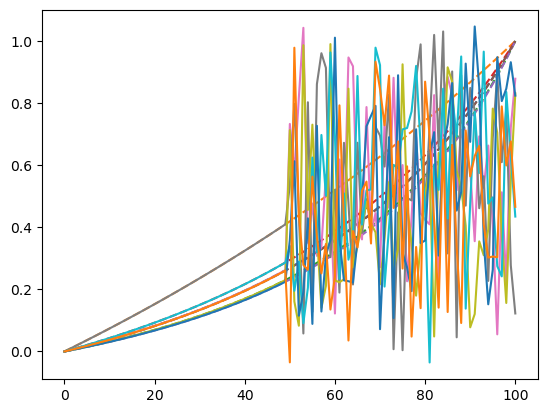

In [43]:
plt.plot(x0.squeeze().cpu()[:6, :].T, '--')
plt.plot(synthetic.squeeze()[:6, :].T, '-')


In [44]:
X.std([2]).shape

torch.Size([462030, 1])

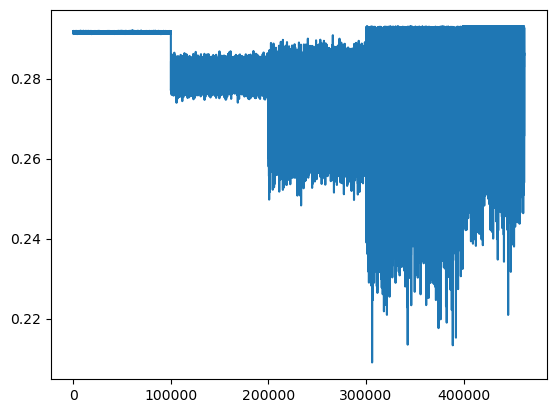

In [45]:
plt.plot(X.std([2]).cpu())

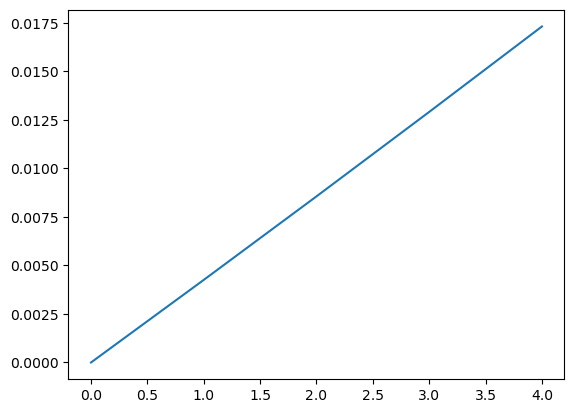

In [46]:
plt.plot(synthetic.squeeze()[:,:5].mean(0))

In [47]:
x0.shape

torch.Size([32, 1, 101])

In [53]:
np.save('x0.npy', x0.squeeze().cpu().numpy())

In [54]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id='smasadzadeh/machine-degradation', filename='model_def.py')

model_def.py: 0.00B [00:00, ?B/s]

'/Users/Mohammad/.cache/huggingface/hub/models--smasadzadeh--machine-degradation/snapshots/8319ddafe2687c5bc036f58126d3ee90b8133bd0/model_def.py'